In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates
import math
from scipy.ndimage import median_filter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Helper Functions for Pre-processing

In [ ]:
def addMissingRows(df):
  po = 0
  column_names = df.columns.tolist()
  new_df_list = []
  new_df_list.append(column_names)
  new_df_list.append(df.iloc[po].tolist())
  po += 1

  while(po < len(df)):
    curTime = new_df_list[-1][0]
    nexTime = df.iloc[po][0]
    time_diff = (nexTime - curTime).total_seconds()

    new_row = []
    if time_diff > 360:
      new_row_ts = curTime + pd.Timedelta(minutes=5)
      new_row.append(new_row_ts)
      for i in range(1, len(column_names)):
        new_row.append(np.nan)
      new_df_list.append(new_row)
    else:
      new_df_list.append(df.iloc[po].tolist())
      po += 1

  new_df = pd.DataFrame(data=new_df_list[1:][:],
                        columns=new_df_list[0][:])

  return new_df


#detect for how long groups of duplicates are present
def detectDuplicateTimestampsRange(df):
  duplicate_timestamps = df[df['Timestamp'].duplicated(keep=False)]['Timestamp']

  range = []
  startTS = None
  endTS = None
  for timestamp in duplicate_timestamps:
    if(startTS == None):
      startTS = timestamp
      endTS = timestamp
    elif(timestamp - endTS <= pd.Timedelta(minutes=5)):
      endTS = timestamp
    else:
      range.append([startTS, endTS])
      startTS = None
      endTS = None

  if(startTS != None):
    range.append([startTS, endTS])

  return range


# store range for which data is missing per day
def findMissingDataRanges(df):
  arr = df.to_numpy()

  start_time = arr[0][0]
  end_time = start_time
  missing_cols = []
  for j in range(1,len(arr[0])):
      if(math.isnan(arr[0][j])):
          missing_cols.append(j)

  #contains start time, end time, missing columns
  final_arr = []
  final_arr_ele = []
  flag = 0

  for i in range(len(arr)):
      flag = 0
      tmissing_cols = []
      for j in range(1,len(arr[i])):
          if(math.isnan(arr[i][j])):
              tmissing_cols.append(j)

      if tmissing_cols == missing_cols and arr[i][0].day == start_time.day:
          end_time = arr[i][0]
      else:
          if(arr[i][0].day != start_time.day):
              end_time == arr[i][0]
          flag = 1
          final_arr_ele.append(start_time)
          final_arr_ele.append(end_time)
          for j in range(len(missing_cols)):
              final_arr_ele.append(missing_cols[j])
          missing_cols = tmissing_cols[:]
          start_time = arr[i][0]
          end_time = start_time
          final_arr.append(final_arr_ele)
          final_arr_ele = []

  if(flag == 0):
      final_arr_ele.append(start_time)
      final_arr_ele.append(end_time)
      for j in range(len(missing_cols)):
          final_arr_ele.append(missing_cols[j])
      final_arr.append(final_arr_ele)
      final_arr_ele = []

  for i in range(len(final_arr)):
    for j in range(2, len(final_arr[i])):
      final_arr[i][j] = df.columns[final_arr[i][j]]

  return final_arr


# Find avg difference between pv and load each day. For days where this avg difference is low, remove those days
def removeClosePVLoad(df_interpolated):
  df_interpolated['load_pv_diff'] = abs(df_interpolated['LOAD POWER (KW)'] - df_interpolated['PV POWER (KW)'])
  df_interpolated['Date'] = df_interpolated['Timestamp'].dt.date
  daily_diff = df_interpolated.groupby('Date')['load_pv_diff'].mean().reset_index()
  # print(daily_diff[daily_diff['Date'] == pd.Timestamp(year=2024, month=4, day=22).date()])

  removedDays = []
  for i in range(len(daily_diff)):
    if(daily_diff.iloc[i]['load_pv_diff'] < 10):
      removedDays.append(daily_diff.iloc[i]['Date'])

  df_interpolated.drop(columns=['Date'], inplace=True)
  df_interpolated.drop(columns=['load_pv_diff'], inplace=True)

  return df_interpolated, removedDays


# Pre-processing Stuff

In [ ]:
'''
1) Convert to appropriate data types
2) Replace [u.] with NaN
3) Add missing rows
4) For duplicate timestamps keep the first timestamp and drop the rest
5) If load/pv is -ve or pv bw 7pm to 5am is not 0, make it 0
6) If range of missing data is greater than 1 hr, remove that day's data
7) Interpolate missing data using spline interpolation
8) Perform hampel filter for outlier removal
9) If load and pv are almost same, remove that day's data
'''
def preprocessing(file_path, removeDups=True):
  df = pd.read_csv(file_path)
  df = df.rename(columns={df.columns[0]: 'Timestamp'})
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], format="%d.%m.%Y %H:%M:%S")
  while(len(df.columns) > 5):
    df.drop(columns=df.columns[-1], inplace=True)

  pattern = r'\[u\.\]'
  df = df.replace(to_replace=pattern, value=-9999, regex=True)
  df.iloc[:, 1:] = df.iloc[:, 1:].astype(float)
  df = df.replace(-9999, np.nan)
  df = addMissingRows(df)

  if removeDups:
    df = df.drop_duplicates(subset=['Timestamp'], keep='first', ignore_index=True)

  #replace negative values with 0
  df['LOAD POWER (KW)'] = df['LOAD POWER (KW)'].apply(lambda x: x if np.isnan(x) else max(x, 0))
  #replace pv bw 7pm to 5am to 0
  time_condition = (df['Timestamp'].dt.hour >= 19) | (df['Timestamp'].dt.hour <= 5)
  valid_power_condition = pd.notna(df['PV POWER (KW)'])
  condition = time_condition & valid_power_condition
  df.loc[condition, 'PV POWER (KW)'] = 0

  #add days with lots of missing data to removed days
  removedDays = []
  missingDataRanges = findMissingDataRanges(df)
  for i in range(len(missingDataRanges)):
    if(missingDataRanges[i][2:] == []):
      continue
    if(missingDataRanges[i][1] - missingDataRanges[i][0] > pd.Timedelta(hours=1)):
      removedDays.append(missingDataRanges[i][0].date())

  # df['Date'] = df['Timestamp'].dt.date
  # df_filtered = df[~df['Date'].isin(removedDays)]
  # df_filtered.drop(columns=['Date'], inplace=True)
  # df.drop(columns=['Date'], inplace=True)
  df_filtered = df.copy()

  #interpolate missing points
  df_filtered_columns = df_filtered.columns.difference(['Timestamp'])
  for column in df_filtered_columns:
      df_filtered[column] = df_filtered[column].interpolate(method='spline', order=3)

  df_interpolated = df_filtered.copy()

  #apply median filter
  df_filtered_columns = df_interpolated.columns.difference(['Timestamp'])
  for column in df_filtered_columns:
      if column == 'BAT POWER (KW)':
        df_interpolated[column] = median_filter(df_interpolated[column], size=5)
        continue
      df_interpolated[column] = median_filter(df_interpolated[column], size=9)
  df_interpolated.reset_index(drop=True, inplace=True)

  #remove days with almost same load and pv
  df_interpolated, removedPVLoadDays = removeClosePVLoad(df_interpolated)

  return df, df_interpolated, removedDays, removedPVLoadDays

# Misc Functions

In [ ]:
def plotDay(df, day, month, year):
  plt.clf()
  filtered_df = df[(df['Timestamp'].dt.day == day) &
                 (df['Timestamp'].dt.month == month) &
                 (df['Timestamp'].dt.year == year)]
  index_positions = filtered_df.index.tolist()
  df = df.iloc[index_positions]

  # for column in range(1, len(df.columns)):
  #     plt.plot(df['Timestamp'], df.iloc[:, column], label=df.columns[column].capitalize())

  plt.plot(df['Timestamp'], df.iloc[:, 3], label=df.columns[3].capitalize())
  plt.plot(df['Timestamp'], df.iloc[:, 2], label=df.columns[2].capitalize())
  plt.plot(df['Timestamp'], df.iloc[:, 1], label=df.columns[1].capitalize())
  plt.plot(df['Timestamp'], df.iloc[:, 4], label=df.columns[4].capitalize())


  ax = plt.gca()
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))


  plt.xlabel(str(day) + '/' + str(month) + '/' + str(year))
  plt.ylabel('Values')
  plt.title('Line Plot of Load, Grid, Battery, and PV over Time')
  plt.legend()
  plt.grid(True)
  plt.show()

def printMissingDataRange(missingDataRanges):
  for i in missingDataRanges:
    if(i[2:] == []):
      continue

    startDate = f"{i[0].day:02}/{i[0].month:02}/{i[0].year} {i[0].hour:02}:{i[0].minute:02}"
    endDate = f"{i[1].day:02}/{i[1].month:02}/{i[1].year} {i[1].hour:02}:{i[1].minute:02}"

    print("Date Range: ", startDate, ' to ', endDate)
    print('Missing Columns: ', '\n', i[2:])
    print('\n')



def heatmap(df):
  tdf = df.copy()
  tdf['Date'] = tdf['Timestamp'].dt.strftime('%d/%m/%Y')
  tdf.set_index('Date', inplace=True)
  tdf.drop(columns=['Timestamp'], inplace=True)
  sns.heatmap(tdf.isnull(), cmap='viridis')
  plt.show()


In [ ]:
file_path = "drive/MyDrive/smart power grid data/Battery load grid pv data/Lane32 01-03-2024 to 31-05-2024.csv"
# file_path = "drive/MyDrive/smart power grid data/Battery load grid pv data/convertcsv.csv"


df, df_interpolated, removedDays, removedPVLoadDays = preprocessing(file_path, removeDups=True)
# df2, df_interpolated2, removedDays2, removedPVLoadDays2 = preprocessing(file_path2, removeDups=True)


duplicates = detectDuplicateTimestampsRange(df)
for duplicate in duplicates:
  print(duplicate)

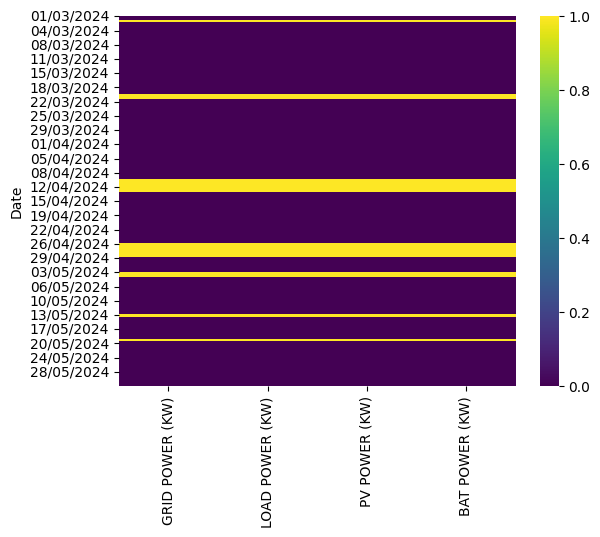

In [ ]:
heatmap(df)
# heatmap(df_interpolated2)

In [ ]:
# missingDataRanges = findMissingDataRanges(df)
# printMissingDataRange(missingDataRanges)
# missingDataRanges

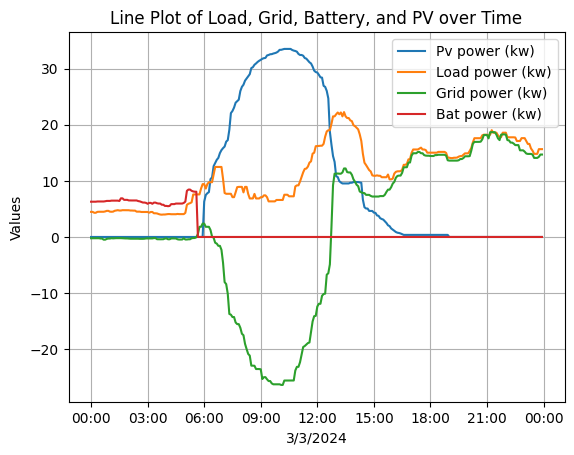

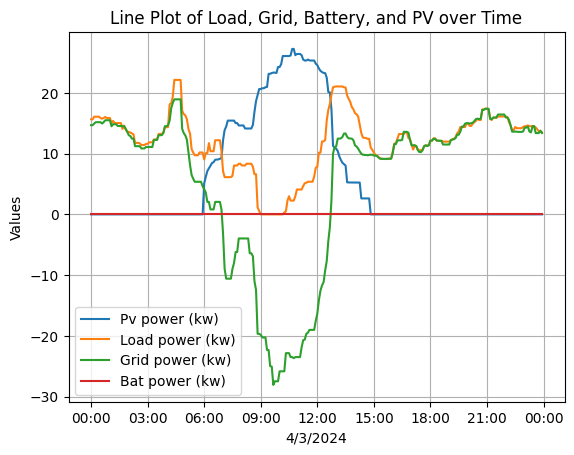

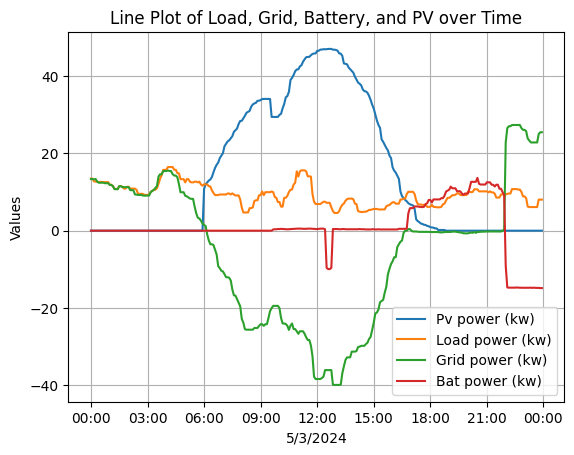

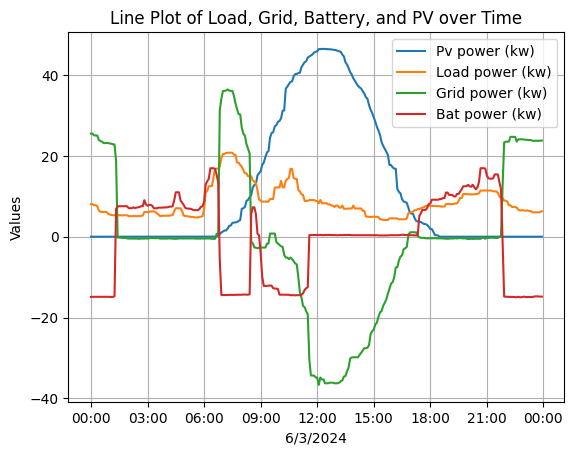

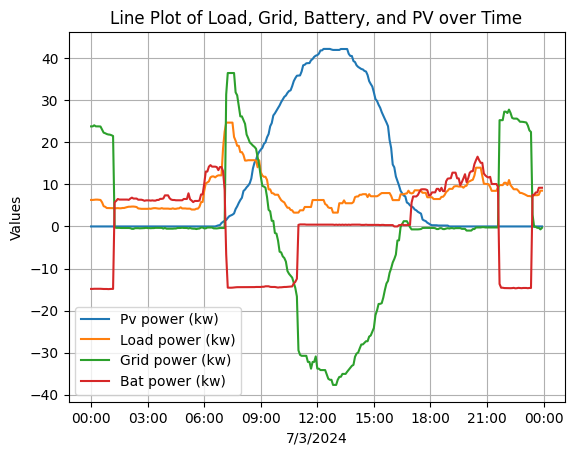

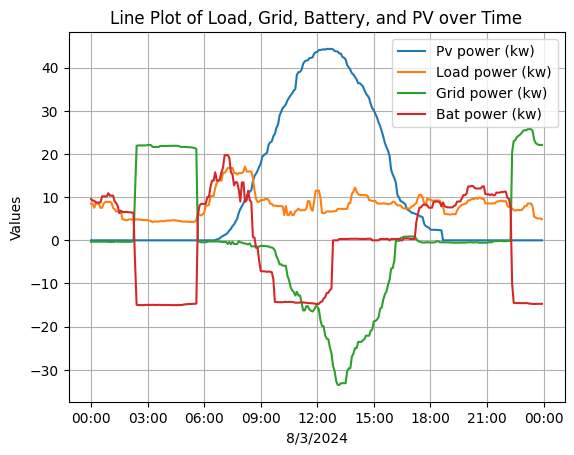

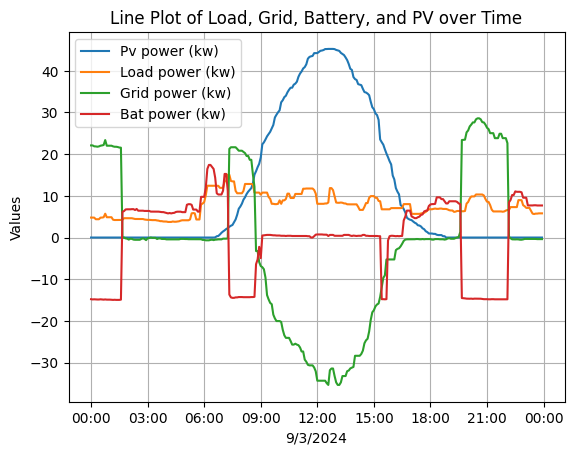

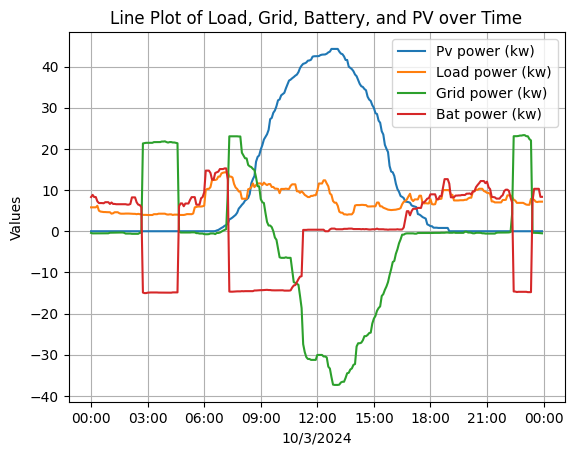

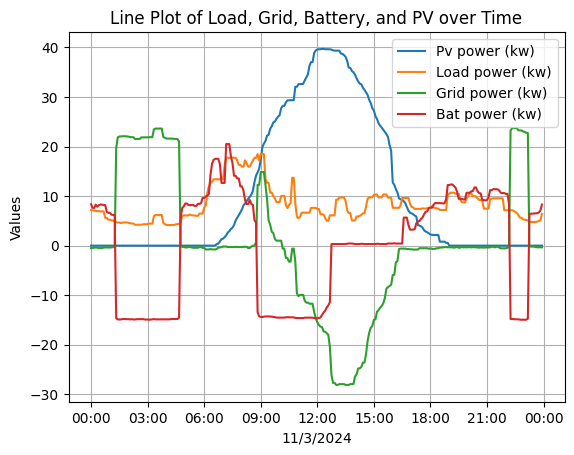

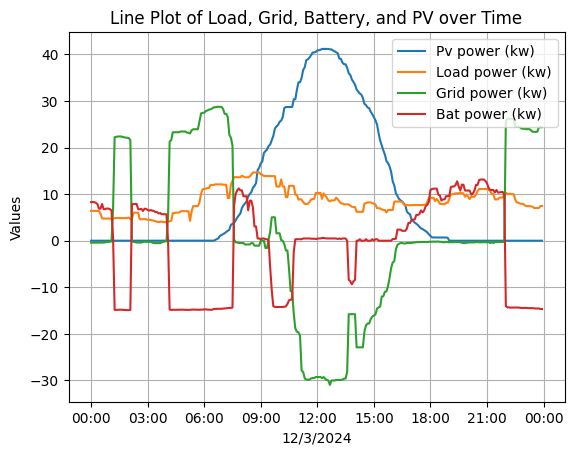

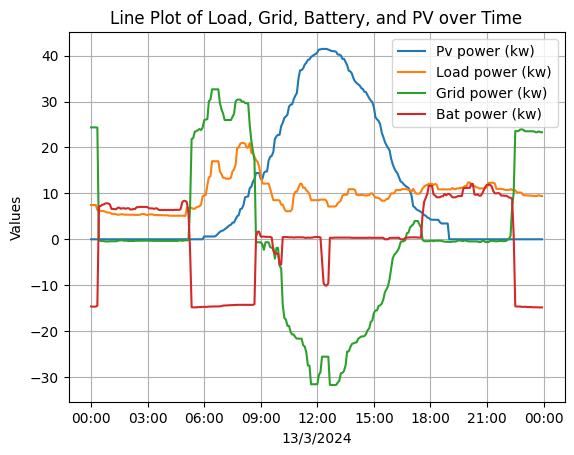

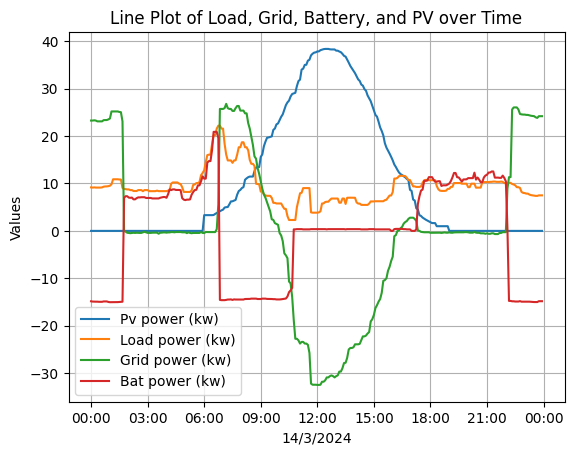

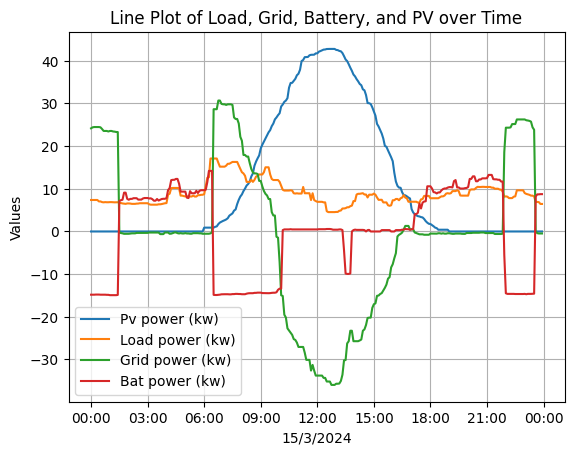

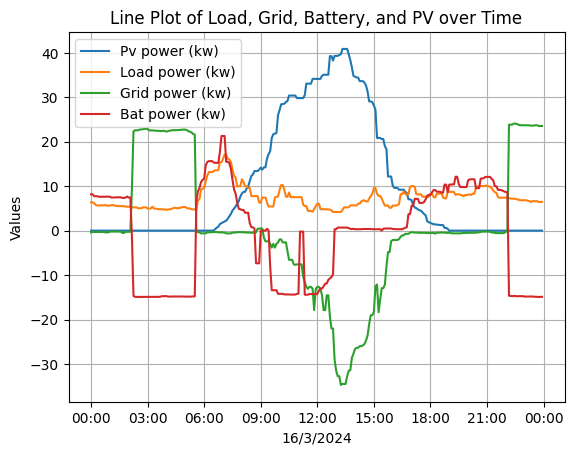

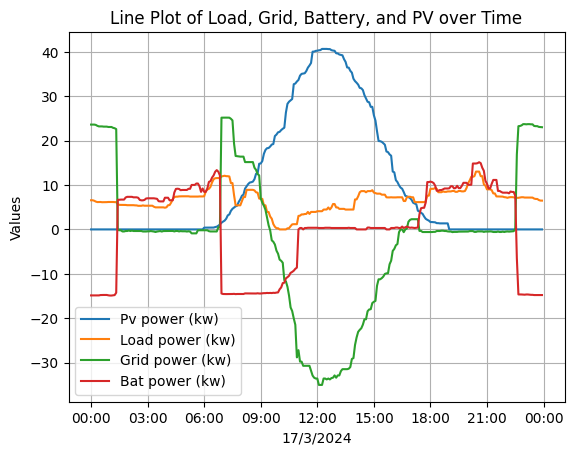

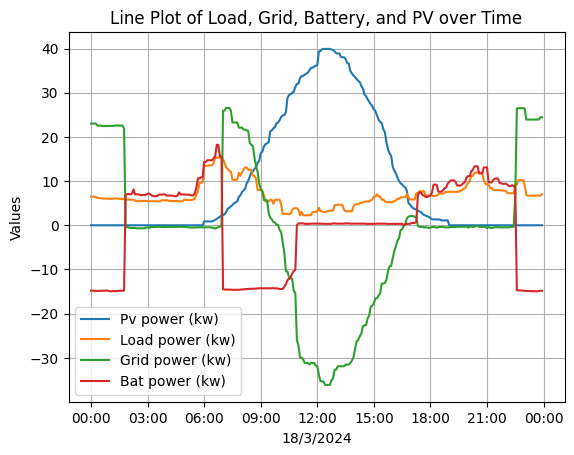

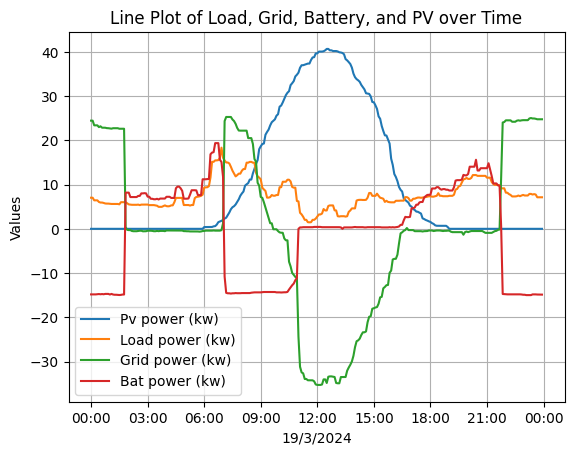

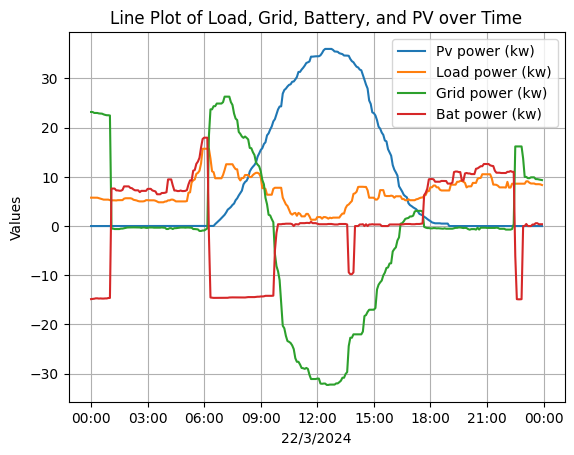

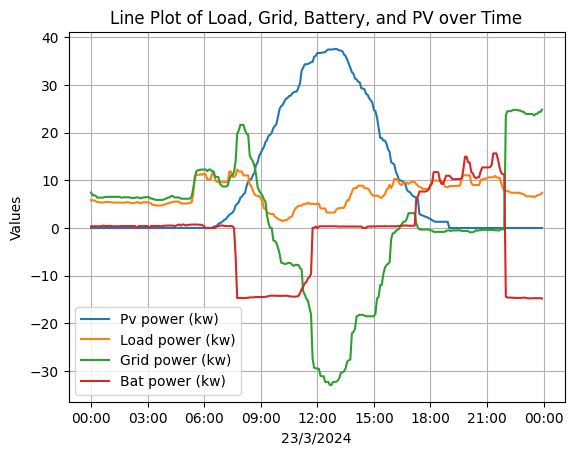

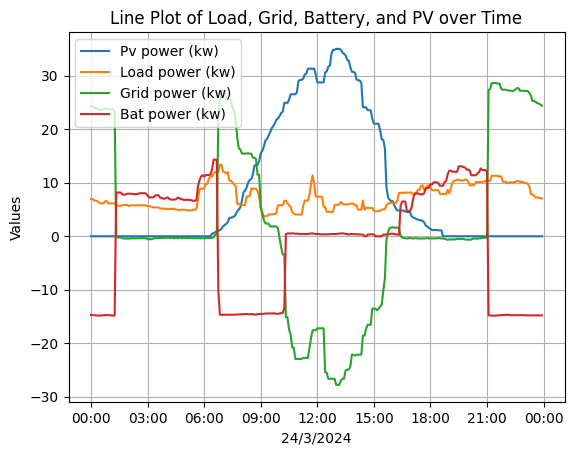

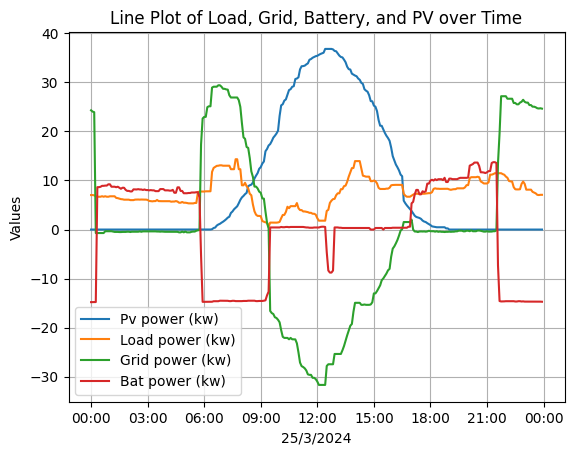

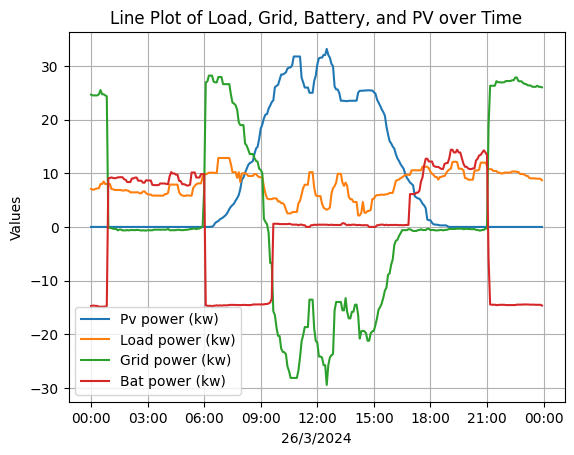

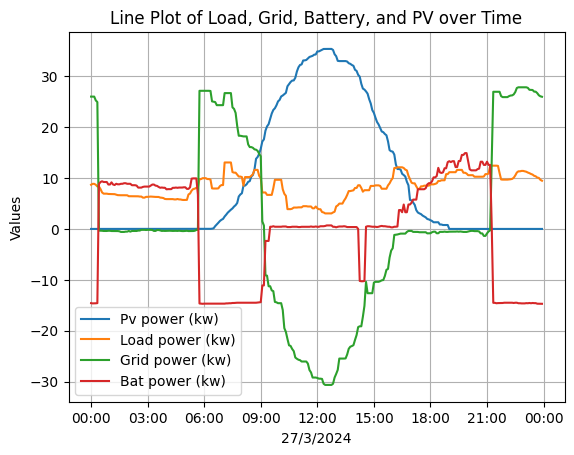

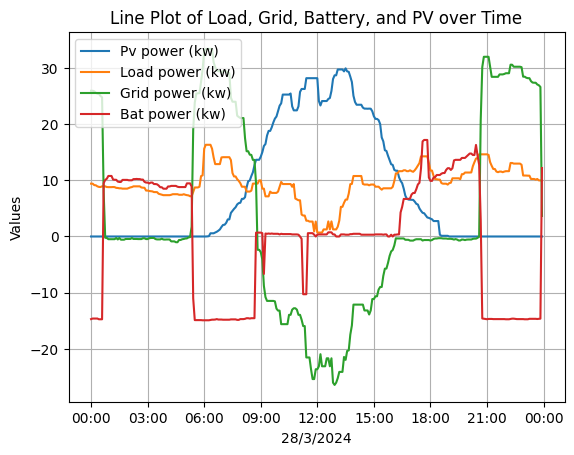

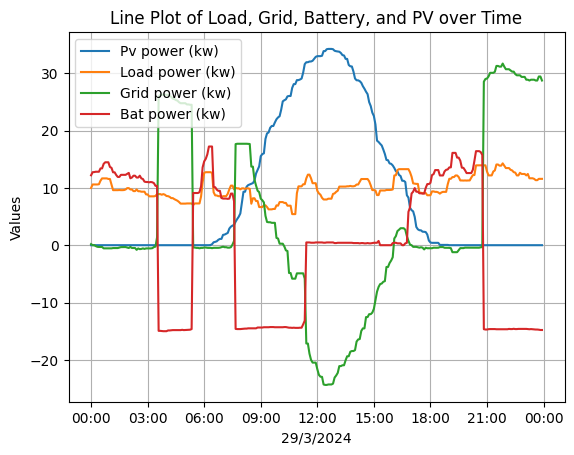

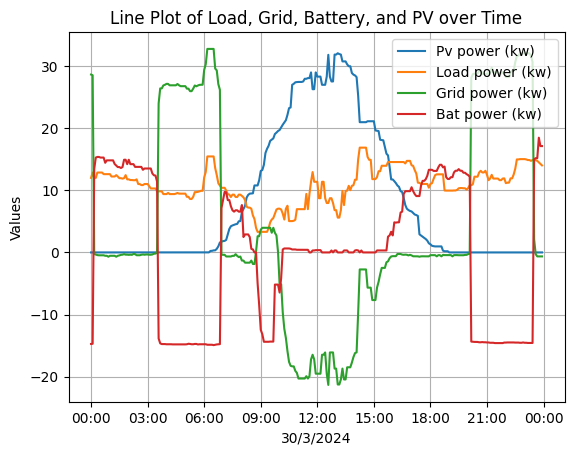

In [ ]:
# for i in removedDays:
#   plotDay(df, i.day, i.month, i.year)

# for i in removedPVLoadDays:
#   plotDay(df, i.day, i.month, i.year)


# print(removedDays)

for i in range(1, 31):
  if (pd.Timestamp(year=2024, month=3, day=i).date() in removedDays or
      pd.Timestamp(year=2024, month=3, day=i).date() in removedPVLoadDays):
    continue

  plotDay(df_interpolated.copy(), i, 3, 2024)
  # plotDay(df, i, 3, 2024)


# 24th april is weird for battery

# Plotting Bar graphs

In [ ]:
import calendar

def plotDailyBar(df, day, month, year, removedDays, removedPVLoadDays):
  # df['BAT POWER (KW)'] = df['BAT POWER (KW)'].apply(lambda x: x if np.isnan(x) else min(x, 0))

  daily_df = df.resample('D', on='Timestamp').sum()
  daily_df = daily_df.loc[pd.Timestamp(year=year, month=month, day=day)]

  date_object = pd.to_datetime(f"{year}-{month}-{day}").date()

  #Show data not available if given day belongs to removed days
  if date_object in removedDays or date_object in removedPVLoadDays:
      fig, ax = plt.subplots(figsize=(8, 6))

      # Text for "Not Available"
      text = "Data Not Available"
      x_center = 0.5
      y_center = 0.5

      annotation = ax.annotate(text, xy=(x_center, y_center),
                              xycoords='axes fraction',  # Use axes fraction coordinates
                              horizontalalignment='center', verticalalignment='center',
                              fontsize=16)
      plt.show()
      return


  # Plotting
  plt.clf()
  heights = [daily_df['LOAD POWER (KW)'], daily_df['BAT POWER (KW)'], daily_df['PV POWER (KW)'], daily_df['GRID POWER (KW)']]
  bars = ['LOAD POWER (KW)', 'BAT POWER (KW)', 'PV POWER (KW)', 'GRID POWER (KW)']
  bar_colors = ['tab:red', 'tab:red', 'tab:blue', 'tab:blue']
  bar_labels = ['Demand', '_Demand', 'Generation', '_Generation']

  x_pos = [0,2,5,7]
  plt.bar(x_pos, heights, color=bar_colors, width=1.5, label=bar_labels)

  plt.xticks(x_pos, bars, rotation=45)


  # plt.xlabel('Date')
  plt.ylabel('Total')
  plt.title(f'Daily Parameters {day}/{month}/{year}')

  plt.legend(bar_labels, title='Parameters')
  plt.grid(True)

  for i, height in enumerate(heights):
    bar_width = 1
    plt.text(x_pos[i], max(100, height + 50), str(round(height, 2)), ha='center')

  plt.show()


def plotMonthlyBar(df, month, year, removedDays, removedPVLoadDays, genOrDem='gen'):
  df['BAT POWER (KW)'] = df['BAT POWER (KW)'].apply(lambda x: x if np.isnan(x) else max(x, 0))
  df['GRID POWER (KW)'] = df['GRID POWER (KW)'].apply(lambda x: x if np.isnan(x) else max(x, 0))

  columns_toNan = ['LOAD POWER (KW)', 'BAT POWER (KW)', 'PV POWER (KW)', 'GRID POWER (KW)']
  df['Date'] = df['Timestamp'].dt.date
  all_removed_days = set(removedDays).union(removedPVLoadDays)
  df.loc[df['Date'].isin(all_removed_days), columns_toNan] = np.nan
  df.drop(columns=['Date'], inplace=True)

  monthly_df = df[(df['Timestamp'].dt.month == month) & (df['Timestamp'].dt.year == year)]
  monthly_df = monthly_df.resample('D', on='Timestamp').sum()

  # Plotting
  plt.clf()
  fig, ax = plt.subplots(figsize=(19, 8))  # Adjust the figure size as needed

  # Plot each remaining column as an overlapping bar
  if genOrDem == 'gen':
    gen_monthly_df = monthly_df.drop(columns=['LOAD POWER (KW)', 'BAT POWER (KW)'])
  else:
    gen_monthly_df = monthly_df.drop(columns=['PV POWER (KW)', 'GRID POWER (KW)'])

  i_ = 0
  for column in gen_monthly_df.columns:
    i_ += 1
    if(i_ == 1):
      bars = ax.bar(gen_monthly_df.index, gen_monthly_df[column], label=column, alpha=0.7, width=0.8, color='#5483bf')
    else:
      bars = ax.bar(gen_monthly_df.index, gen_monthly_df[column], label=column, alpha=0.7, width=0.4, color='#d15c5c')

      # for bar in bars:
      #   height = bar.get_height()
      #   ax.annotate(f'{height:.2f}',
      #       xy=(bar.get_x() + bar.get_width() / 2, height),
      #       xytext=(0, 5),  # Increase vertical offset
      #       textcoords="offset points",
      #       ha='center', va='bottom',
      #       fontsize=8)  # Reduce font size

  ax.set_xticks(gen_monthly_df.index)
  ax.set_xticklabels([d.day for d in gen_monthly_df.index])

  # Set labels and title
  ax.set_xlabel('Day')
  ax.set_ylabel('Values (KW)')

  if genOrDem == 'gen':
    ax.set_title(f'Generation parameters {calendar.month_name[month]} {year}')
  else:
    ax.set_title(f'Demand parameters {calendar.month_name[month]} {year}')
  ax.legend()
  ax.grid(True)

  plt.show()

def plotMonthlyGridExport(df, month, year, removedDays, removedPVLoadDays):
  df['GRID POWER (KW)'] = df['GRID POWER (KW)'].apply(lambda x: x if np.isnan(x) else min(x, 0))
  df['GRID POWER (KW)'] = df['GRID POWER (KW)'].apply(lambda x: x if np.isnan(x) else -1*x)

  columns_toNan = ['LOAD POWER (KW)', 'BAT POWER (KW)', 'PV POWER (KW)', 'GRID POWER (KW)']
  df['Date'] = df['Timestamp'].dt.date
  all_removed_days = set(removedDays).union(removedPVLoadDays)
  df.loc[df['Date'].isin(all_removed_days), columns_toNan] = np.nan
  df.drop(columns=['Date'], inplace=True)

  monthly_df = df[(df['Timestamp'].dt.month == month) & (df['Timestamp'].dt.year == year)]
  monthly_df = monthly_df.resample('D', on='Timestamp').sum()

  monthly_mean = monthly_df.replace(0, np.nan).resample('M').mean()
  print("MEAN EXPORT: \n\n", monthly_mean)

  # Plotting
  plt.clf()
  fig, ax = plt.subplots(figsize=(15, 8))  # Adjust the figure size as needed

  bars = ax.bar(monthly_df.index, monthly_df['GRID POWER (KW)'], label='GRID POWER (KW)', alpha=0.7, width=0.75, color='#5483bf')

  ax.set_xticks(monthly_df.index)
  ax.set_xticklabels([d.day for d in monthly_df.index])

  # Set labels and title
  ax.set_xlabel('Day')
  ax.set_ylabel('Values (KW)')

  ax.set_title(f'Grid Export {calendar.month_name[month]} {year}')
  ax.legend()
  ax.grid(True)

  plt.show()


#Bring up missing days point
def plotWeeklyBar(df, day, month, year, removedDays, removedPVLoadDays, genOrDem='gen'):
  df['BAT POWER (KW)'] = df['BAT POWER (KW)'].apply(lambda x: x if np.isnan(x) else max(x, 0))

  columns_toNan = ['LOAD POWER (KW)', 'BAT POWER (KW)', 'PV POWER (KW)', 'GRID POWER (KW)']
  df['Date'] = df['Timestamp'].dt.date
  all_removed_days = set(removedDays).union(removedPVLoadDays)
  df.loc[df['Date'].isin(all_removed_days), columns_toNan] = np.nan
  df.drop(columns=['Date'], inplace=True)

  weekly_df = df[(df['Timestamp'].dt.month == month) & (df['Timestamp'].dt.year == year) & (df['Timestamp'].dt.day >= day) & (df['Timestamp'].dt.day < day + 7)]
  weekly_df = weekly_df.resample('D', on='Timestamp').sum()

  # Plotting
  plt.clf()
  fig, ax = plt.subplots(figsize=(15, 8))  # Adjust the figure size as needed

  # Plot each remaining column as an overlapping bar
  if genOrDem == 'gen':
    gen_monthly_df = weekly_df.drop(columns=['LOAD POWER (KW)', 'BAT POWER (KW)'])
  else:
    gen_monthly_df = weekly_df.drop(columns=['PV POWER (KW)', 'GRID POWER (KW)'])

  i_ = 0
  for column in gen_monthly_df.columns:
    i_ += 1
    if(i_ == 1):
      bars = ax.bar(gen_monthly_df.index, gen_monthly_df[column], label=column, alpha=0.7, width=0.75, color='#5483bf')
    else:
      bars = ax.bar(gen_monthly_df.index, gen_monthly_df[column], label=column, alpha=0.7, width=0.45, color='#d15c5c')

      # for bar in bars:
      #   height = bar.get_height()
      #   ax.annotate(f'{height:.2f}',
      #       xy=(bar.get_x() + bar.get_width() / 2, height),
      #       xytext=(0, 5),  # Increase vertical offset
      #       textcoords="offset points",
      #       ha='center', va='bottom',
      #       fontsize=8)  # Reduce font size

  print(gen_monthly_df)
  ax.set_xticks(gen_monthly_df.index)
  ax.set_xticklabels([str(d.day) + '/' + str(d.month) + '/' + str(d.year) for d in gen_monthly_df.index])

  # Set labels and title
  ax.set_xlabel('Day')
  ax.set_ylabel('Values (KW)')

  if genOrDem == 'gen':
    ax.set_title(f'Generation parameters for week {day}/{month}/{year}')
  else:
    ax.set_title(f'Demand parameters for week {day}/{month}/{year}')
  ax.legend()
  ax.grid(True)

  plt.show()

<Figure size 640x480 with 0 Axes>

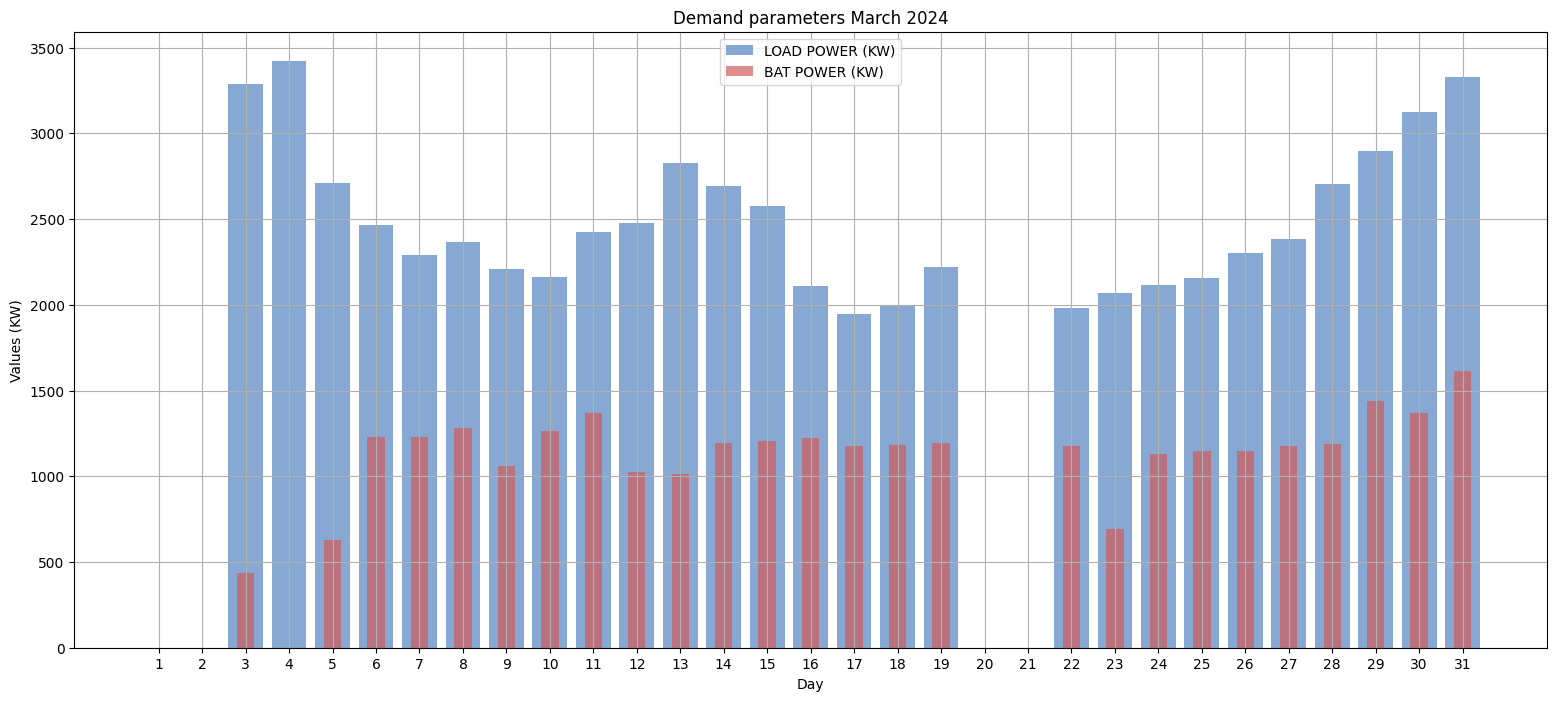

In [ ]:
# plotDailyBar(df_interpolated.copy(), 9, 4, 2024, removedDays, removedPVLoadDays)
# plotMonthlyBar(df_interpolated.copy(), 3, 2024, removedDays, removedPVLoadDays, 'gen')
# plotMonthlyGridExport(df_interpolated.copy(), 3, 2024, removedDays, removedPVLoadDays)
plotMonthlyBar(df_interpolated.copy(), 3, 2024, removedDays, removedPVLoadDays, 'dem')
# plotWeeklyBar(df_interpolated.copy(), 20, 3, 2024, removedDays, removedPVLoadDays, 'gen')
# plotWeeklyBar(df_interpolated.copy(), 20, 3, 2024, removedDays, removedPVLoadDays, 'dem')

# Plot Pie Chart

In [ ]:
def plotWeeklyPieChart(df, day, month, year, removedDays, removedPVLoadDays):
  # df['GRID POWER (KW)'] = df['GRID POWER (KW)'].apply(lambda x: x if np.isnan(x) else max(x, 0))

  df['Date'] = df['Timestamp'].dt.date
  df = df[~df['Date'].isin(removedDays)]
  df = df[~df['Date'].isin(removedPVLoadDays)]
  df.drop(columns=['Date'], inplace=True)

  weekly_df = df[(df['Timestamp'].dt.month == month) & (df['Timestamp'].dt.year == year) & (df['Timestamp'].dt.day >= day) & (df['Timestamp'].dt.day < day + 7)]
  # weekly_df = weekly_df.resample('D', on='Timestamp').sum()

  # weekly_df['NET POWER (KW)'] = weekly_df['GRID POWER (KW)'] + weekly_df['PV POWER (KW)'] - weekly_df['LOAD POWER (KW)'] + weekly_df['BAT POWER (KW)']
  weekly_df['NET POWER (KW)'] = weekly_df['GRID POWER (KW)'] + weekly_df['PV POWER (KW)']
  pv_percentage = (weekly_df['PV POWER (KW)'].sum() / weekly_df['NET POWER (KW)'].sum()) * 100
  # batt_percentage = (weekly_df['BAT POWER (KW)'].sum() / weekly_df['NET POWER (KW)'].sum()) * 100
  grid_percentage = (weekly_df['GRID POWER (KW)'].sum() / weekly_df['NET POWER (KW)'].sum()) * 100

  # labels = ['PV Power', 'Battery Power', 'Grid Power']
  # sizes = [pv_percentage, batt_percentage, grid_percentage]
  labels = ['PV Power', 'Grid Power']
  sizes = [pv_percentage, grid_percentage]


  # for i in range(len(sizes)):
  #   if sizes[i] < 0:
  #     sizes[i] = 0

  def autopct_format(pct, allvalues):
      absolute = int(pct/100.*np.sum(allvalues))
      return f"{pct:.1f}%\n({absolute:d} KW)"

  print(sizes)

  # Plotting pie chart
  plt.figure(figsize=(8, 8))
  # explode = (0.1, 0.1, 0.1)
  explode = (0.1, 0.1)
  plt.pie(sizes, labels=labels, autopct=lambda pct: autopct_format(pct, sizes), startangle=140, colors=['gold', 'lightgreen'], explode=explode)
  plt.title(f'Power Distribution for week {day}/{month}/{year}')
  plt.show()

def plotMonthlyPieChart(df, month, year, removedDays, removedPVLoadDays):
  df['BAT POWER (KW)'] = df['BAT POWER (KW)'].apply(lambda x: x if np.isnan(x) else max(x, 0))
  df['GRID POWER (KW)'] = df['GRID POWER (KW)'].apply(lambda x: x if np.isnan(x) else max(x, 0))

  df['Date'] = df['Timestamp'].dt.date
  df = df[~df['Date'].isin(removedDays)]
  df = df[~df['Date'].isin(removedPVLoadDays)]
  df.drop(columns=['Date'], inplace=True)

  monthly_df = df[(df['Timestamp'].dt.month == month) & (df['Timestamp'].dt.year == year)]
  monthly_df = monthly_df.resample('M', on='Timestamp').sum()

  # monthly_df['NET POWER (KW)'] = monthly_df['GRID POWER (KW)'] + monthly_df['PV POWER (KW)'] - monthly_df['LOAD POWER (KW)'] + monthly_df['BAT POWER (KW)']
  monthly_df['NET POWER (KW)'] = monthly_df['GRID POWER (KW)'] + monthly_df['PV POWER (KW)']
  pv_percentage = (monthly_df['PV POWER (KW)'].sum() / monthly_df['NET POWER (KW)'].sum()) * 100
  # batt_percentage = (monthly_df['BAT POWER (KW)'].sum() / monthly_df['NET POWER (KW)'].sum()) * 100
  grid_percentage = (monthly_df['GRID POWER (KW)'].sum() / monthly_df['NET POWER (KW)'].sum()) * 100

  # labels = ['PV Power', 'Battery Power', 'Grid Power']
  # sizes = [pv_percentage, batt_percentage, grid_percentage]
  labels = ['PV Power', 'Grid Power']
  sizes = [pv_percentage, grid_percentage]


  for i in range(len(sizes)):
    if sizes[i] < 0:
      sizes[i] = 0

  def autopct_format(pct, allvalues):
      absolute = int(pct/100.*np.sum(allvalues))
      return f"{pct:.1f}%\n({absolute:d} KW)"

  # Plotting pie chart
  plt.figure(figsize=(8, 8))
  explode = (0.1, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')
  plt.pie(sizes, labels=labels, autopct=lambda pct: autopct_format(pct, sizes), startangle=140, colors=['gold', 'lightgreen'], explode=explode)
  month_name = calendar.month_name[month]
  plt.title(f'Power Distribution for {month_name} {year}')
  plt.show()

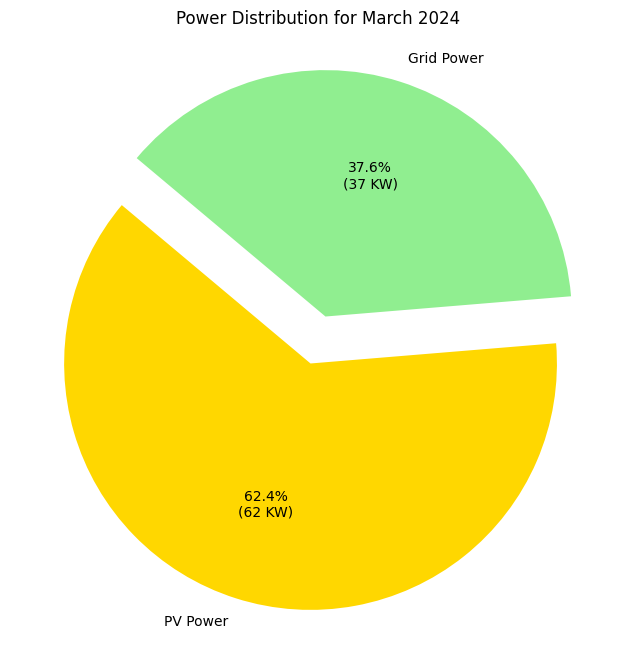

In [ ]:
plotMonthlyPieChart(df_interpolated.copy(), 3, 2024, removedDays, removedPVLoadDays)
# plotWeeklyPieChart(df_interpolated.copy(), 20, 4, 2024, removedDays, removedPVLoadDays)

# Find Island Mode Duration

In [ ]:
def islandMonth(df, month, year, removedDays, removedPVLoadDays):
  df['BAT POWER (KW)'] = df['BAT POWER (KW)'].apply(lambda x: x if np.isnan(x) else max(x, 0))
  monthly_df = df[(df['Timestamp'].dt.month == month) & (df['Timestamp'].dt.year == year)]

  # islanded_df = monthly_df[(monthly_df['GRID POWER (KW)'] >= -0.5) & (monthly_df['GRID POWER (KW)'] <= 0.5)]
  islanded_df = monthly_df[(monthly_df['GRID POWER (KW)'] == 0)]
  islanded_df['Date'] = islanded_df['Timestamp'].dt.date
  df_filtered = islanded_df
  df_filtered = islanded_df[~islanded_df['Date'].isin(removedDays)]
  df_filtered = df_filtered[~df_filtered['Date'].isin(removedPVLoadDays)]

  return (len(df_filtered)*5)/60

In [ ]:
print(islandMonth(df_interpolated.copy(), 3, 2024, removedDays, removedPVLoadDays))

2.5833333333333335


<ipython-input-186-6436e073a0e3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  islanded_df['Date'] = islanded_df['Timestamp'].dt.date


# Discharge vs Load

In [ ]:
def findMonthlyDischarge(df, month, year, removedDays, removedPVLoadDays):
  df['BAT POWER (KW)'] = df['BAT POWER (KW)'].apply(lambda x: x if np.isnan(x) else max(x, 0))

  columns_toNan = ['LOAD POWER (KW)', 'BAT POWER (KW)', 'PV POWER (KW)', 'GRID POWER (KW)']
  df['Date'] = df['Timestamp'].dt.date
  all_removed_days = set(removedDays).union(removedPVLoadDays)
  df.loc[df['Date'].isin(all_removed_days), columns_toNan] = np.nan
  df.drop(columns=['Date'], inplace=True)

  monthly_df = df[(df['Timestamp'].dt.month == month) & (df['Timestamp'].dt.year == year)]

  #dont count days where battery is 0 because thats mostly invalid data
  monthly_df = monthly_df.resample('D', on='Timestamp').sum()
  monthly_df = monthly_df[~(monthly_df['BAT POWER (KW)'] == 0)]

  netLoad = monthly_df['LOAD POWER (KW)'].sum()
  discharge = monthly_df['BAT POWER (KW)'].sum()

  return discharge*100/netLoad

In [ ]:
findMonthlyDischarge(df_interpolated.copy(), 3, 2024, removedDays, removedPVLoadDays)

46.692435251963694

# Additional Graphs

In [ ]:
def plotAll(df, month, year, removedDays, removedPVLoadDays):
  df['GRID POWER (KW)'] = df['GRID POWER (KW)'].apply(lambda x: x if np.isnan(x) else max(x, 0))
  df['BAT POWER (KW)'] = df['BAT POWER (KW)'].apply(lambda x: x if np.isnan(x) else max(x, 0))

  columns_toNan = ['LOAD POWER (KW)', 'BAT POWER (KW)', 'PV POWER (KW)', 'GRID POWER (KW)']
  df['Date'] = df['Timestamp'].dt.date
  all_removed_days = set(removedDays).union(removedPVLoadDays)
  df.loc[df['Date'].isin(all_removed_days), columns_toNan] = np.nan
  df.drop(columns=['Date'], inplace=True)

  monthly_df = df[(df['Timestamp'].dt.month == month) & (df['Timestamp'].dt.year == year)]
  monthly_df = monthly_df.resample('D', on='Timestamp').sum()

  # PLOT GRID IMPORT
  plt.clf()
  fig, ax = plt.subplots(figsize=(15, 8))  # Adjust the figure size as needed

  bars = ax.bar(monthly_df.index, monthly_df['GRID POWER (KW)'], label='GRID POWER (KW)', alpha=0.7, width=0.75, color='#5483bf')

  ax.set_xticks(monthly_df.index)
  ax.set_xticklabels([d.day for d in monthly_df.index])

  # Set labels and title
  ax.set_xlabel('Day')
  ax.set_ylabel('Values (KW)')

  ax.set_title(f'Grid Import {calendar.month_name[month]} {year}')
  ax.legend()
  ax.grid(True)

  plt.show()


  # PLOT PV GENERATED
  plt.clf()
  fig, ax = plt.subplots(figsize=(15, 8))  # Adjust the figure size as needed

  bars = ax.bar(monthly_df.index, monthly_df['PV POWER (KW)'], label='PV POWER (KW)', alpha=0.7, width=0.75, color='#f70e0e')

  ax.set_xticks(monthly_df.index)
  ax.set_xticklabels([d.day for d in monthly_df.index])

  # Set labels and title
  ax.set_xlabel('Day')
  ax.set_ylabel('Values (KW)')

  ax.set_title(f'PV Generated {calendar.month_name[month]} {year}')
  ax.legend()
  ax.grid(True)

  plt.show()


  # PLOT LOAD
  plt.clf()
  fig, ax = plt.subplots(figsize=(15, 8))  # Adjust the figure size as needed

  bars = ax.bar(monthly_df.index, monthly_df['LOAD POWER (KW)'], label='LOAD POWER (KW)', alpha=0.7, width=0.75, color='#ccd629')

  ax.set_xticks(monthly_df.index)
  ax.set_xticklabels([d.day for d in monthly_df.index])

  # Set labels and title
  ax.set_xlabel('Day')
  ax.set_ylabel('Values (KW)')

  ax.set_title(f'Load {calendar.month_name[month]} {year}')
  ax.legend()
  ax.grid(True)

  plt.show()


  # PLOT BATTERY DISCHARGE
  plt.clf()
  fig, ax = plt.subplots(figsize=(15, 8))  # Adjust the figure size as needed

  bars = ax.bar(monthly_df.index, monthly_df['BAT POWER (KW)'], label='BAT POWER (KW)', alpha=0.7, width=0.75, color='#0d5f4c')

  ax.set_xticks(monthly_df.index)
  ax.set_xticklabels([d.day for d in monthly_df.index])

  # Set labels and title
  ax.set_xlabel('Day')
  ax.set_ylabel('Values (KW)')

  ax.set_title(f'Battery Discharge {calendar.month_name[month]} {year}')
  ax.legend()
  ax.grid(True)

  plt.show()



<Figure size 640x480 with 0 Axes>

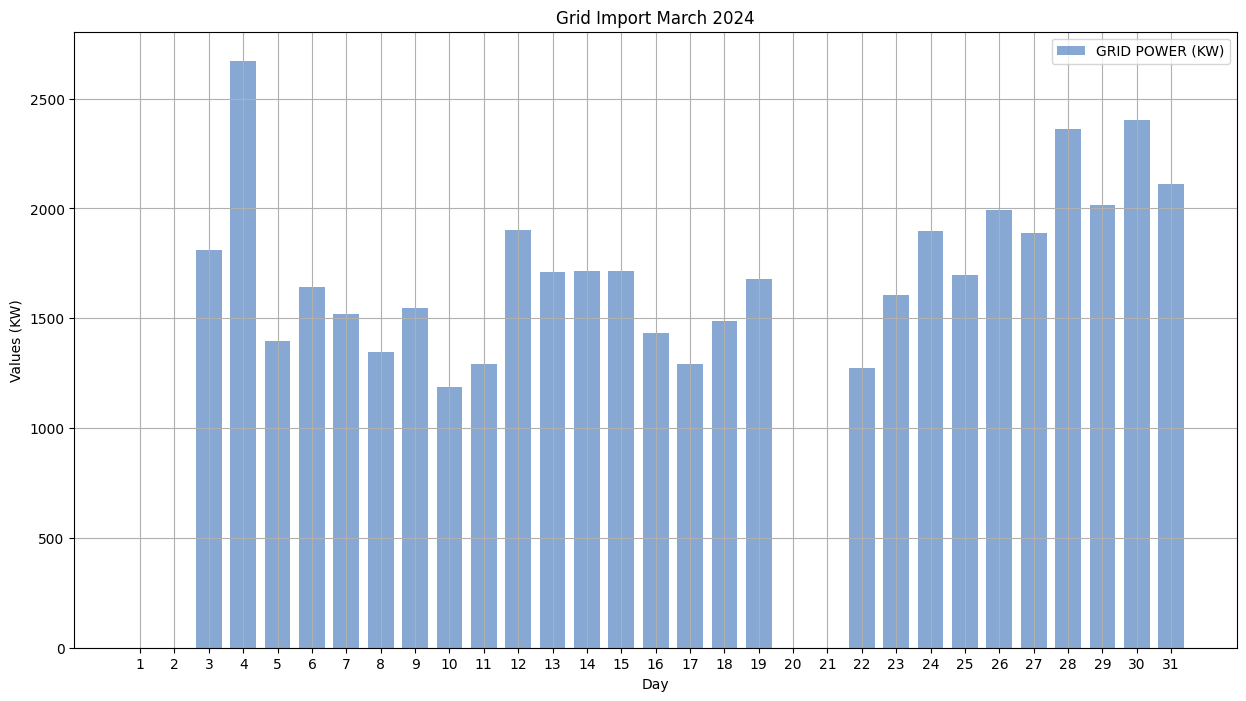

<Figure size 640x480 with 0 Axes>

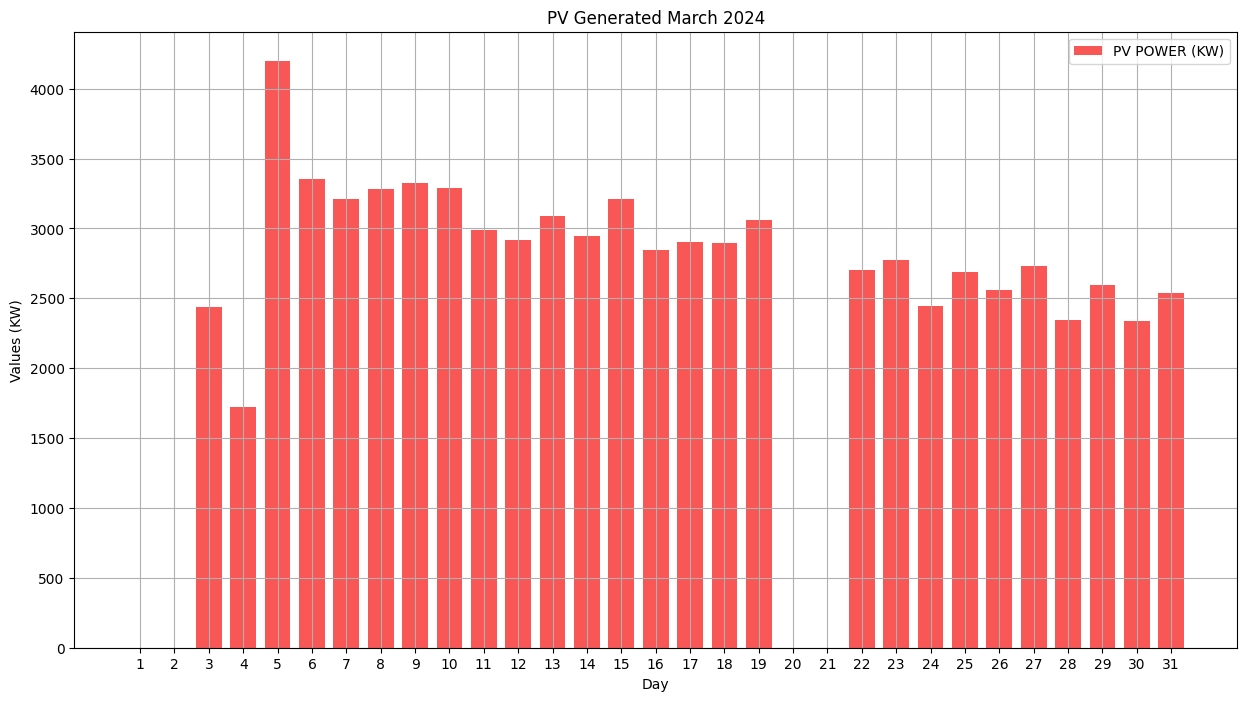

<Figure size 640x480 with 0 Axes>

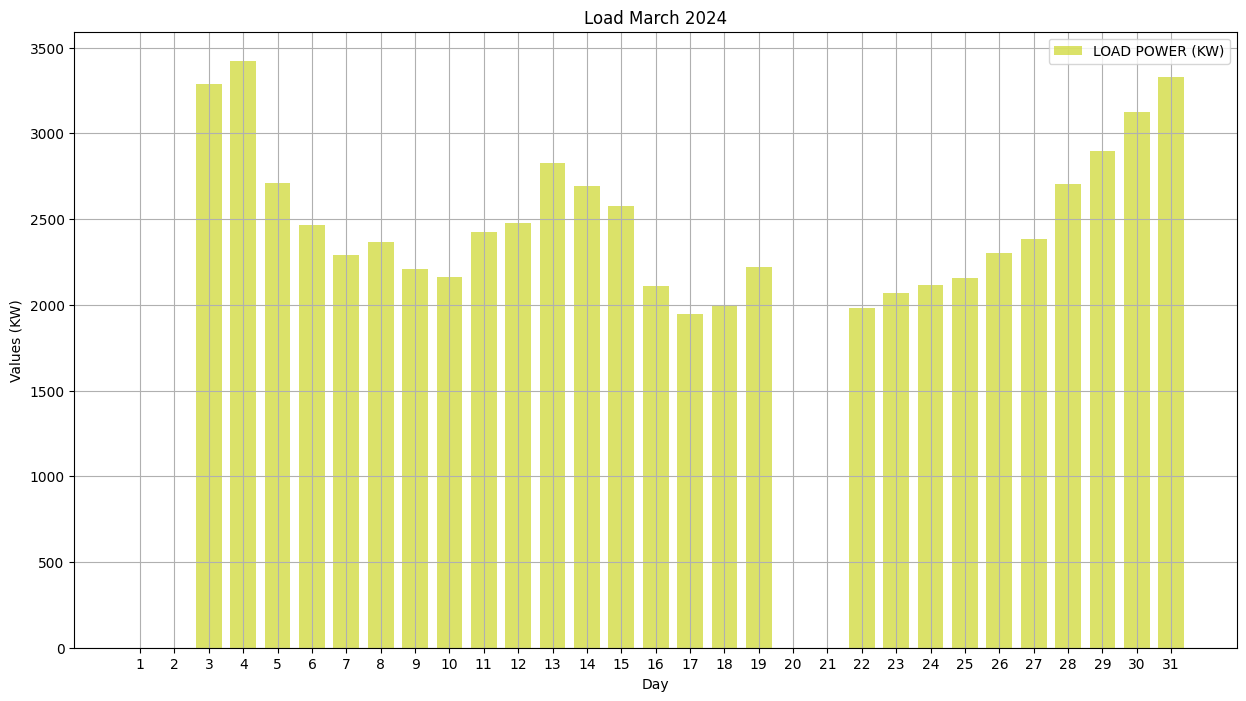

<Figure size 640x480 with 0 Axes>

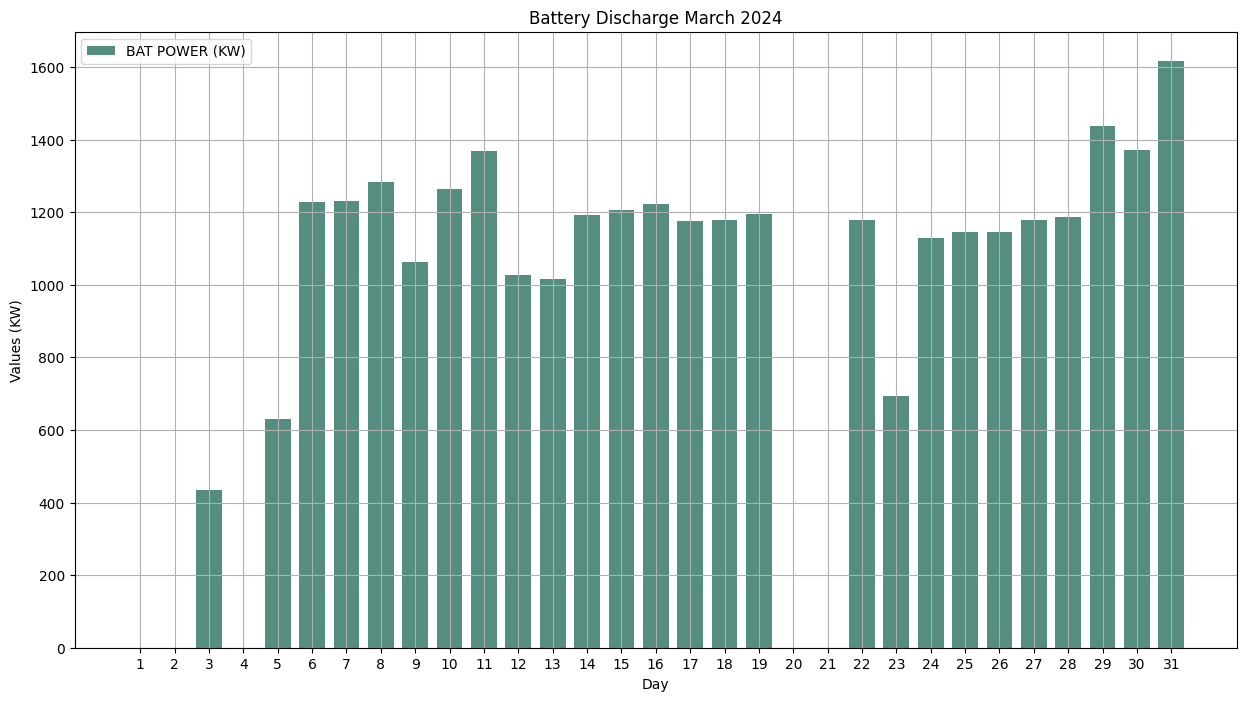

In [ ]:
plotAll(df_interpolated.copy(), 3, 2024, removedDays, removedPVLoadDays)

# PV compared to actual load

In [ ]:
def plotActualPVLoad(df, month, year, removedDays, removedPVLoadDays):
  # df['BAT POWER (KW)'] = df['BAT POWER (KW)'].apply(lambda x: x if np.isnan(x) else max(x, 0))
  # df['GRID POWER (KW)'] = df['GRID POWER (KW)'].apply(lambda x: x if np.isnan(x) else max(x, 0))

  columns_toNan = ['LOAD POWER (KW)', 'BAT POWER (KW)', 'PV POWER (KW)', 'GRID POWER (KW)']
  df['Date'] = df['Timestamp'].dt.date
  all_removed_days = set(removedDays).union(removedPVLoadDays)
  df.loc[df['Date'].isin(all_removed_days), columns_toNan] = np.nan
  df.drop(columns=['Date'], inplace=True)

  monthly_df = df[(df['Timestamp'].dt.month == month) & (df['Timestamp'].dt.year == year)]
  monthly_df['LOAD POWER (KW)'] = monthly_df['GRID POWER (KW)'] + monthly_df['PV POWER (KW)']
  monthly_df['PV POWER (KW)'] = monthly_df['PV POWER (KW)'] + monthly_df['GRID POWER (KW)'].apply(lambda x: x if np.isnan(x) else min(x, 0))
  # monthly_df['GRID POWER (KW)'] =  monthly_df['GRID POWER (KW)'].apply(lambda x: x if np.isnan(x) else max(x, 0))


  temp_df = monthly_df.resample('M', on='Timestamp').sum()
  print("Average Contribution Load: ", (temp_df['PV POWER (KW)'] * 100 / temp_df['LOAD POWER (KW)']))

  monthly_df = monthly_df.resample('D', on='Timestamp').sum()

  # Plotting
  plt.clf()
  fig, ax = plt.subplots(figsize=(19, 8))  # Adjust the figure size as needed

  # Plot each remaining column as an overlapping bar
  gen_monthly_df = monthly_df.drop(columns=['BAT POWER (KW)', 'GRID POWER (KW)'])

  i_ = 0
  for column in gen_monthly_df.columns:
    i_ += 1
    if(i_ == 1):
      bars = ax.bar(gen_monthly_df.index, gen_monthly_df[column], label=column, alpha=0.7, width=0.8, color='#5483bf')
    else:
      bars = ax.bar(gen_monthly_df.index, gen_monthly_df[column], label=column, alpha=0.7, width=0.4, color='#d15c5c')
  ax.set_xticks(gen_monthly_df.index)
  ax.set_xticklabels([d.day for d in gen_monthly_df.index])

  # Set labels and title
  ax.set_xlabel('Day')
  ax.set_ylabel('Values (KW)')

  ax.set_title(f'Solar PV contribution to Load {calendar.month_name[month]} {year}')
  ax.legend()
  ax.grid(True)

  plt.show()

Average Contribution Load:  Timestamp
2024-03-31    42.207773
Freq: M, dtype: float64


<ipython-input-210-52882c2f6742>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_df['LOAD POWER (KW)'] = monthly_df['GRID POWER (KW)'] + monthly_df['PV POWER (KW)']
<ipython-input-210-52882c2f6742>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_df['PV POWER (KW)'] = monthly_df['PV POWER (KW)'] + monthly_df['GRID POWER (KW)'].apply(lambda x: x if np.isnan(x) else min(x, 0))


<Figure size 640x480 with 0 Axes>

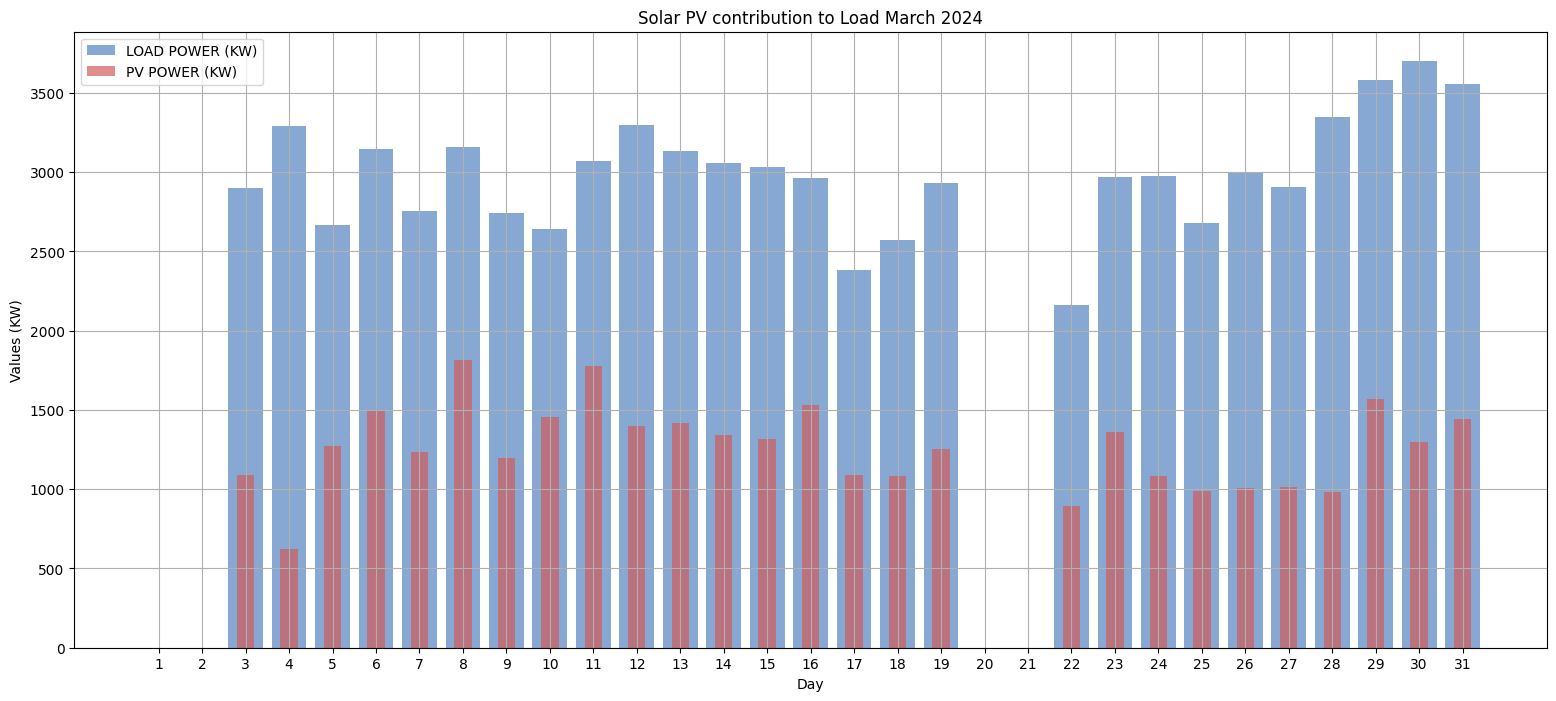

In [ ]:
plotActualPVLoad(df_interpolated.copy(), 3, 2024, removedDays, removedPVLoadDays)